In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sys
import os
from PIL import Image
import json
from sklearn.utils import shuffle
from cache import cache
import pydot
import graphviz
from sklearn.model_selection import train_test_split

In [3]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding

from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.preprocessing import image

from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

from tensorflow.python.keras.utils import plot_model

In [4]:
tf.__version__

'1.12.0'

In [5]:
tf.keras.__version__

'2.1.6-tf'

In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14792540810231827899
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6694395576
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16277377141754251686
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:04:00.0, compute capability: 6.1"
]


### VGG16 or InceptionV3?

In [4]:
vgg16 = VGG16()

W0708 03:14:00.419271 140208842925888 deprecation.py:506] From /home/catnado/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


553467904/553467096 [==============================] - 6s 0us/step


In [5]:
print(vgg16.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
inception_v3 = tf.keras.applications.InceptionV3(weights='imagenet')

96116736/96112376 [==============================] - 1s 0us/step


In [10]:
print(inception_v3.summary())

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

### Download COCO dataset

In [6]:
os.path.abspath('.')

'E:\\Projects\\Image_Caption'

In [7]:
# download caption file
if not os.path.exists(os.path.abspath('.') + '/annotations/'):
    annotation_zip = tf.keras.utils.get_file('captions.zip', 
                                              cache_subdir=os.path.abspath('.'),
                                              origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                              extract = True)
    annotation_file_train = os.path.abspath('.')+'/annotations/captions_train2014.json'
    annotation_file_val = os.path.abspath('.')+'/annotations/captions_val2014.json'
else:
    annotation_file_train = os.path.abspath('.')+'/annotations/captions_train2014.json'
    annotation_file_val = os.path.abspath('.')+'/annotations/captions_val2014.json'
    

In [8]:
print(annotation_file_train)
print(annotation_file_val)

E:\Projects\Image_Caption/annotations/captions_train2014.json
E:\Projects\Image_Caption/annotations/captions_val2014.json


In [9]:
# download training set image file
name_of_zip = 'train2014.zip'
if not os.path.exists(os.path.abspath('.') + '/' + name_of_zip):
    image_zip = tf.keras.utils.get_file(name_of_zip,
                                        cache_subdir=os.path.abspath('.'),
                                        origin = 'http://images.cocodataset.org/zips/' + name_of_zip,
                                        extract = True)
    train_path = os.path.dirname(image_zip)+'/train2014/train2014/'
else:
    train_path = os.path.abspath('.')+'/train2014/train2014/'

In [10]:
# download validation set image file
name_of_zip = 'val2014.zip'
if not os.path.exists(os.path.abspath('.') + '/' + name_of_zip):
    image_zip = tf.keras.utils.get_file(name_of_zip,
                                        cache_subdir=os.path.abspath('.'),
                                        origin = 'http://images.cocodataset.org/zips/' + name_of_zip,
                                        extract = True)
    val_path = os.path.dirname(image_zip)+'/val2014/'
else:
    val_path = os.path.abspath('.')+'/val2014/'

In [11]:
print(train_path)
print(val_path)

E:\Projects\Image_Caption/train2014/train2014/
E:\Projects\Image_Caption/val2014/


In [12]:
# load training set
with open(annotation_file_train, 'r') as f:
    annotations = json.load(f)
    
# storing the captions and the image name in vectors
filenames_train = []
captions_train = []

for annot in annotations['annotations']:
    caption = ' ' + annot['caption'] + ' '
    image_id = annot['image_id']
    full_coco_image_path = train_path + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    filenames_train.append(full_coco_image_path)
    captions_train.append(caption)
    
unique_image_train = len(annotations['images'])

In [13]:
# load validation set
with open(annotation_file_val, 'r') as f:
    annotations = json.load(f)
    
# storing the captions and the image name in vectors
filenames_val = []
captions_val = []

for annot in annotations['annotations']:
    caption = ' ' + annot['caption'] + ' '
    image_id = annot['image_id']
    full_coco_image_path = val_path + 'COCO_val2014_' + '%012d.jpg' % (image_id)

    filenames_val.append(full_coco_image_path)
    captions_val.append(caption)

unique_image_val = len(annotations['images'])

In [14]:
print("training set image: " + str(len(filenames_train)))
print("training set unique image: " + str(unique_image_train))
print("training set caption: " + str(len(captions_train)))

print("validation set image: " + str(len(filenames_val)))
print("validation set unique image: " + str(unique_image_val))
print("validation set caption: " + str(len(captions_val)))

training set image: 414113
training set unique image: 82783
training set caption: 414113
validation set image: 202654
validation set unique image: 40504
validation set caption: 202654


In [15]:
filenames_train[0]

'E:\\Projects\\Image_Caption/train2014/train2014/COCO_train2014_000000318556.jpg'

### Show some example image

In [16]:
def load_image(path, size=None):
    """
    Load the image from the given file-path and resize it
    to the given size if not None.
    """

    # Load the image using PIL.
    img = Image.open(path)

    # Resize image if desired.
    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)

    # Convert image to numpy array.
    img = np.array(img)

    # Scale image-pixels so they fall between 0.0 and 1.0
    img = img / 255.0

    # Convert 2-dim gray-scale array to 3-dim RGB array.
    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

    return img

In [240]:
def show_image(path, caption):
    """
    Load and plot an image from the training- or validation-set
    with the given index.
    """

    #path = filenames_train[idx]
    #caption = captions_train[idx]

    # Print the captions for this image.
    print(caption)
    
    # Load the image and plot it.
    img = load_image(path)
    plt.imshow(img)
    plt.show()

 A graffiti-ed stop sign across the street from a red car  


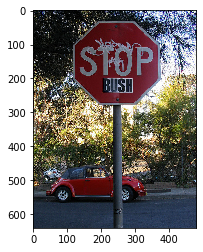

In [244]:
show_image(filenames_train[4], captions_train[4])

### CNN Image Encoder - VGG16

In [19]:
image_model = VGG16(include_top=True, weights='imagenet')
image_model_transfer = Model(inputs=image_model.input,
                             outputs=image_model.get_layer('fc2').output)
img_size = K.int_shape(image_model.input)[1:3]
transfer_values_size = K.int_shape(image_model_transfer.output)[1]

In [20]:
print(img_size)
print(transfer_values_size)

(224, 224)
4096


In [21]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

In [22]:
def process_images(filepaths, batch_size=16):
    """
    Process all the given files in the given data_dir using the
    pre-trained image-model and return their transfer-values.
    
    Note that we process the images in batches to save
    memory and improve efficiency on the GPU.
    """
    
    # Number of images to process.
    num_images = len(filepaths)

    # Pre-allocate input-batch-array for images.
    shape = (batch_size,) + img_size + (3,)
    image_batch = np.zeros(shape=shape, dtype=np.float16)

    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (num_images, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    # Initialize index into the filenames.
    start_index = 0

    # Process batches of image-files.
    while start_index < num_images:
        # Print the percentage-progress.
        print_progress(count=start_index, max_count=num_images)

        # End-index for this batch.
        end_index = start_index + batch_size

        # Ensure end-index is within bounds.
        if end_index > num_images:
            end_index = num_images

        # The last batch may have a different batch-size.
        current_batch_size = end_index - start_index

        # Load all the images in the batch.
        for i, path in enumerate(filepaths[start_index:end_index]):
            
            # Load and resize the image.
            # This returns the image as a numpy-array.
            img = load_image(path, size=img_size)

            # Save the image for later use.
            image_batch[i] = img
            
        # Use the pre-trained image-model to process the image.
        # Note that the last batch may have a different size,
        # so we only use the relevant images.
        transfer_values_batch = image_model_transfer.predict(image_batch[0:current_batch_size])

            
        # Save the transfer-values in the pre-allocated array.
        transfer_values[start_index:end_index] = transfer_values_batch[0:current_batch_size]

        # Increase the index for the next loop-iteration.
        start_index = end_index

    # Print newline.
    print()

    return transfer_values

In [23]:
def process_images_train():
    print("Processing {0} images in training-set ...".format(len(sorted(set(filenames_train)))))

    # Path for the cache-file.
    cache_path = os.path.abspath('.') + '/transfer_values_train.pkl'

    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            filepaths=sorted(set(filenames_train)))

    return transfer_values

In [24]:
%%time
transfer_values_train = process_images_train()
print("dtype:", transfer_values_train.dtype)
print("shape:", transfer_values_train.shape)

Processing 82783 images in training-set ...
- Data loaded from cache-file: E:\Projects\Image_Caption/transfer_values_train.pkl
dtype: float16
shape: (82783, 4096)
Wall time: 7.25 s


In [25]:
# create a dict for looking up transfer values
unique_image = sorted(set(filenames_train))
transfer_values_train_lookup = dict(zip(unique_image, transfer_values_train))

### Tokenize

In [26]:
captions_train_marked = ['<start>' + caption + '<end>' for caption in captions_train]

In [71]:
vocab_size = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, 
                                                  oov_token="<unk>", 
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(captions_train_marked)
tokenizer.word_index = {key:value for key, value in tokenizer.word_index.items() if value <= vocab_size}
#tokenizer.word_index['<pad>'] = 0

index_word = {value:key for key, value in tokenizer.word_index.items()}
train_seqs = tokenizer.texts_to_sequences(captions_train_marked)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post', truncating='post')

# max number of tokens
num_tokens = [len(t) for t in train_seqs]
max_tokens = np.max(num_tokens)

In [72]:
train_seqs[:5]

[[3, 2, 142, 509, 10, 621, 416, 276, 58, 4],
 [3, 2, 3993, 171, 6, 2, 62, 10, 316, 6, 155, 615, 4],
 [3, 2, 60, 10, 22, 58, 9, 2936, 1963, 136, 1223, 4],
 [3, 2, 3993, 162, 6, 2, 62, 10, 462, 44, 4],
 [3, 2, 643, 7108, 148, 59, 241, 7, 25, 97, 2, 48, 130, 4]]

In [73]:
captions_train_marked[:5]

['<start> A very clean and well decorated empty bathroom <end>',
 '<start> A panoramic view of a kitchen and all of its appliances. <end>',
 '<start> A blue and white bathroom with butterfly themed wall tiles. <end>',
 '<start> A panoramic photo of a kitchen and dining room <end>',
 '<start> A graffiti-ed stop sign across the street from a red car  <end>']

In [74]:
cap_vector[:5]

array([[   3,    2,  142,  509,   10,  621,  416,  276,   58,    4,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [   3,    2, 3993,  171,    6,    2,   62,   10,  316,    6,  155,
         615,    4,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [   3,    2,   60,   10,   22,   58,    9, 2936, 1963,  136, 1223,
           4,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0

### Create Encoder-Decoder Model

In [272]:
model.reset_states()

In [273]:
state_size = 512
embedding_size = 128

# encoder
encoder_inputs = Input(shape=(transfer_values_size,), name='encoder_input')
encoder = Dense(state_size, activation='tanh', name='encoder_output') 
# using tanh to get to -1 to 1 in order to use as initial state 
encoder_outputs = encoder(encoder_inputs)

# decoder
decoder_inputs = Input(shape=(None, ), name='decoder_input')
decoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_size, name='decoder_embedding')
embedding = decoder_embedding(decoder_inputs)
decoder_gru = GRU(state_size, return_sequences=True, name='decoder_gru')
decoder_outputs = decoder_gru(embedding, initial_state=encoder_outputs)
decoder_dense = Dense(vocab_size, activation='softmax', name='decoder_output')
decoder_outputs = decoder_dense(decoder_outputs)

# model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


In [274]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
encoder_input (InputLayer)      (None, 4096)         0                                            
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, None, 128)    1280000     decoder_input[0][0]              
__________________________________________________________________________________________________
encoder_output (Dense)          (None, 512)          2097664     encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_gr

In [275]:
#plot_model(model, to_file='model.png', show_shapes=True)

In [276]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
check_X1train = X1train[:1000]
check_X2train = X2train[:1000]
check_ytrain = ytrain[:1000]

check_X1val = X1val[:300]
check_X2val = X2val[:300]
check_yval = yval[:300]


In [80]:
%time history = model.fit([check_X1train, check_X2train], check_ytrain, epochs=20, verbose=2, callbacks=callbacks,\
                          validation_data=([check_X1val, check_X2val], check_yval))

Train on 1000 samples, validate on 300 samples
Epoch 1/20

Epoch 00001: val_loss did not improve from 1.28099
 - 6s - loss: 2.1601 - val_loss: 1.5467
Epoch 2/20

Epoch 00002: val_loss did not improve from 1.28099
 - 5s - loss: 1.1860 - val_loss: 1.5534
Epoch 3/20

Epoch 00003: val_loss did not improve from 1.28099
 - 4s - loss: 1.1086 - val_loss: 1.4486
Epoch 4/20

Epoch 00004: val_loss did not improve from 1.28099
 - 4s - loss: 1.0399 - val_loss: 1.4141
Epoch 5/20

Epoch 00005: val_loss did not improve from 1.28099
 - 4s - loss: 0.9801 - val_loss: 1.3658
Epoch 6/20

Epoch 00006: val_loss did not improve from 1.28099
 - 4s - loss: 0.9166 - val_loss: 1.3049
Epoch 7/20

Epoch 00007: val_loss did not improve from 1.28099
 - 5s - loss: 0.8694 - val_loss: 1.3002
Epoch 8/20

Epoch 00008: val_loss did not improve from 1.28099
 - 5s - loss: 0.8302 - val_loss: 1.2826
Epoch 9/20

Epoch 00009: val_loss did not improve from 1.28099
 - 4s - loss: 0.7986 - val_loss: 1.3029
Epoch 10/20

Epoch 00010: 

 A graffiti-ed stop sign across the street from a red car  


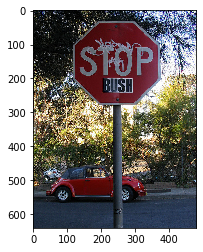

Predicted caption:
 a young boy is standing on a skateboard <end>



In [223]:
generate_caption(4)

 A graffiti-ed stop sign across the street from a red car  


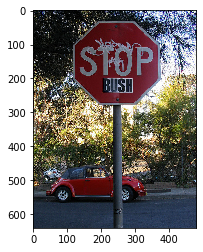

Predicted caption:
 a young boy is standing on a skateboard <end>



In [257]:
generate_caption2(4)

 A graffiti-ed stop sign across the street from a red car  


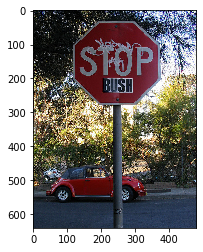

Predicted caption:
<start> a young boy is standing on a skateboard in the background <end>



In [256]:
generate_caption_beam_search(4, beam_width=5)

In [255]:
def generate_caption2(idx, max_tokens=51):
    # encoder outputs
    transfer_values = X1train[idx].reshape((1, 4096))
    encoder_outputs = encoder_model.predict(transfer_values)
    
    # decoder inputs
    shape = (1, max_tokens)
    decoder_inputs = np.zeros((1, max_tokens))
    
    token_int = tokenizer.word_index['<start>']
    token_end = tokenizer.word_index['<end>']
    output_text = ''
    count_tokens = 0
    decoder_inputs[0, count_tokens] = token_int
    
    while token_int != token_end and count_tokens < max_tokens:
        
        decoder_outputs = decoder_model.predict([decoder_inputs, encoder_outputs])
        token_int = np.argmax(decoder_outputs[0, count_tokens, :])
        sampled_word = index_word[token_int]
        output_text += " " + sampled_word
        count_tokens += 1
        decoder_inputs[0, count_tokens] = token_int
        
    # output_tokens = decoder_inputs[0]

    # Plot the image.
    show_image(path_train[idx], caption_train[idx])
    
    # Print the predicted caption.
    print("Predicted caption:")
    print(output_text)
    print()

In [254]:
def generate_caption_beam_search(idx, beam_width=3, max_tokens=51):

    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tokens (words).
    """

    # input X1: transfer values
    transfer_values = X1train[idx].reshape((1, 4096))
    encoder_outputs = encoder_model.predict(transfer_values)
    
    # input X2: word token
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)
    token_int = tokenizer.word_index['<start>']
    token_end = tokenizer.word_index['<end>']
    output_text = ''
    count_tokens = 0
    decoder_input_keep = []
    combined_prob_keep = []

    decoder_input_data[0, count_tokens] = token_int
    decoder_input_keep.append(decoder_input_data)
    combined_prob_keep=[1]

    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while count_tokens < max_tokens:    

        decoder_input_update = []
        prob_update = []                   

        for i in range(len(decoder_input_keep)):

            if decoder_input_keep[i][0, count_tokens] != token_end:

                decoder_output = decoder_model.predict([decoder_input_keep[i], encoder_outputs])
                token_int = np.argsort(decoder_output[0, count_tokens, :])[-beam_width:][::-1]
                prob = decoder_output[0, count_tokens, :][token_int]
                combined_prob = combined_prob_keep[i] * prob
                
                decoder_input = []
                for j in range(beam_width):
                    decoder_input_to_add = decoder_input_keep[i].copy()
                    decoder_input_to_add[0,count_tokens+1] = token_int[j]
                    decoder_input.append(decoder_input_to_add)
                #decoder_input = np.asarray(decoder_input)
                
                prob_update = np.append(prob_update, combined_prob)
                decoder_input_update.extend(decoder_input)

        # update candidate list
        if decoder_input_update == []:
            break
        keepers = np.argsort(prob_update)[-beam_width:][::-1]
        combined_prob_keep = [prob_update[i] for i in keepers] #prob_update[keepers]
        decoder_input_keep = [decoder_input_update[i] for i in keepers]
        count_tokens += 1
        
        

    # This is the sequence of tokens output by the decoder.
    final_keeper = int(np.argsort(combined_prob_keep)[-1:])
    output_tokens = decoder_input_keep[final_keeper]
    output_tokens = output_tokens[0,:].tolist()
    sampled_words = [index_word[i] for i in output_tokens if i != 0]
    output_text = ' '.join(sampled_words)

    show_image(path_train[idx], caption_train[idx])

    print("Predicted caption:")
    print(output_text)
    print()

    

In [56]:
state_size = 512
embedding_size = 128

# encoder
encoder_input = Input(shape=(transfer_values_size,), name='encoder_input')
encoder_output = Dense(state_size, activation='tanh', name='encoder_output') 
# using tanh to get to -1 to 1 in order to use as initial state

# decoder
decoder_input = Input(shape=(None, ), name='decoder_input')
decoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_size, name='decoder_embedding')
decoder_gru1 = GRU(state_size, return_sequences=True, name='decoder_gru1')
decoder_gru2 = GRU(state_size, return_sequences=True, name='decoder_gru2')
decoder_gru3 = GRU(state_size, return_sequences=True, name='decoder_gru3')
decoder_dense = Dense(vocab_size, activation='softmax', name='decoder_output')

# connect layers
initial_state = encoder_output(encoder_input)
net = decoder_embedding(decoder_input)
net = decoder_gru1(net, initial_state=initial_state)
net = decoder_gru2(net, initial_state=initial_state)
net = decoder_gru3(net, initial_state=initial_state)
decoder_output = decoder_dense(net)


# connect and create model
model = Model(inputs=[encoder_input, decoder_input], outputs=decoder_output)


In [57]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
encoder_input (InputLayer)      (None, 4096)         0                                            
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, None, 128)    1280000     decoder_input[0][0]              
__________________________________________________________________________________________________
encoder_output (Dense)          (None, 512)          2097664     encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_gr

In [58]:
#plot_model(model, to_file='model.png', show_shapes=True)

In [37]:
# callback functions

# checkpoint
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
callback_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# tensorboard
callback_tensorboard = TensorBoard(log_dir='./tensorboard_logs/', histogram_freq=0, write_graph=False)

callbacks = [callback_checkpoint, callback_tensorboard]

In [54]:
# load model
try:
    model.load_weights('model-ep010-loss0.814-val_loss1.309.h5')
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [270]:
# prep data
X1 = np.asarray([transfer_values_train_lookup[i] for i in filenames_train])
X2 = np.asarray([caption[:-1] for caption in cap_vector])
y = np.asarray([caption[1:] for caption in cap_vector])
y = y.reshape(y.shape[0], y.shape[1], 1)

In [271]:
X1train, X1val, X2train, X2val, ytrain, yval = train_test_split(X1,X2,y,test_size=0.2,random_state=666)
# Checking the sample counts
print("No of Training Image Vectors:",len(X1train))
print("No of Training Images:",len(X2train))
print("No of Training Caption: ",len(ytrain))
print("No of Validation Image Vectors",len(X1val))
print("No of Validation Images:",len(X2val))
print("No of Validation Caption: ",len(yval))

No of Training Image Vectors: 331290
No of Training Images: 331290
No of Training Caption:  331290
No of Validation Image Vectors 82823
No of Validation Images: 82823
No of Validation Caption:  82823


In [62]:
# compile model
rms = RMSprop(lr=0.001)  #RMS prop works better than adam for RNN models
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=rms)

In [65]:
# fit model
%time history = model.fit([X1train, X2train], ytrain,\
                          epochs=5, verbose=2, \
                          callbacks=callbacks, \
                          validation_data=([X1val, X2val], yval))

Train on 331290 samples, validate on 82823 samples
Epoch 1/5



Epoch 00001: val_loss improved from inf to 0.73530, saving model to model-ep001-loss0.787-val_loss0.735.h5
 - 3228s - loss: 0.7865 - val_loss: 0.7353
Epoch 2/5

Epoch 00002: val_loss did not improve from 0.73530
 - 2867s - loss: 0.7350 - val_loss: 0.7366
Epoch 3/5

Epoch 00003: val_loss improved from 0.73530 to 0.73466, saving model to model-ep003-loss0.729-val_loss0.735.h5


 - 2862s - loss: 0.7288 - val_loss: 0.7347
Epoch 4/5

Epoch 00004: val_loss improved from 0.73466 to 0.73246, saving model to model-ep004-loss0.725-val_loss0.732.h5
 - 2860s - loss: 0.7245 - val_loss: 0.7325
Epoch 5/5



Epoch 00005: val_loss improved from 0.73246 to 0.72833, saving model to model-ep005-loss0.722-val_loss0.728.h5
 - 3129s - loss: 0.7222 - val_loss: 0.7283
Wall time: 4h 9min 7s


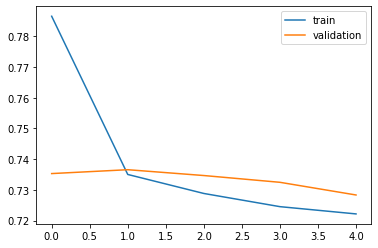

In [66]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation']) 
plt.show()

In [250]:
# prep data
X1train = np.asarray([transfer_values_train_lookup[i] for i in filenames_train])
X2train = np.asarray([caption[:-1] for caption in cap_vector])
ytrain = np.asarray([caption[1:] for caption in cap_vector])

check_X1train = X1train[:1000]
check_X2train = X2train[:1000]
check_ytrain = ytrain[:1000]
check_ytrain = check_ytrain.reshape(check_ytrain.shape[0], check_ytrain.shape[1], 1)

check_X1val = X1train[-300:]
check_X2val = X2train[-300:]
check_yval = ytrain[-300:]
check_yval = check_yval.reshape(check_yval.shape[0], check_yval.shape[1], 1)

path_train = filenames_train[:1000]
caption_train = captions_train[:1000]

In [39]:
# fit model
# should train for 20, try 1 for now
%time history = model.fit([check_X1train, check_X2train], check_ytrain, epochs=10, verbose=2, callbacks=callbacks,\
                          validation_data=([check_X1val, check_X2val], check_yval))

C:\Users\Filabuster\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1000 samples, validate on 300 samples
Epoch 1/10

Epoch 00001: val_loss improved from inf to 1.75102, saving model to model-ep001-loss2.040-val_loss1.751.h5
 - 13s - loss: 2.0405 - val_loss: 1.7510
Epoch 2/10

Epoch 00002: val_loss improved from 1.75102 to 1.51939, saving model to model-ep002-loss1.223-val_loss1.519.h5
 - 10s - loss: 1.2232 - val_loss: 1.5194
Epoch 3/10

Epoch 00003: val_loss did not improve from 1.51939
 - 9s - loss: 1.1456 - val_loss: 3.3006
Epoch 4/10

Epoch 00004: val_loss improved from 1.51939 to 1.42066, saving model to model-ep004-loss1.107-val_loss1.421.h5
 - 9s - loss: 1.1066 - val_loss: 1.4207
Epoch 5/10

Epoch 00005: val_loss did not improve from 1.42066
 - 9s - loss: 1.0325 - val_loss: 1.4340
Epoch 6/10

Epoch 00006: val_loss improved from 1.42066 to 1.40475, saving model to model-ep006-loss1.002-val_loss1.405.h5
 - 9s - loss: 1.0024 - val_loss: 1.4048
Epoch 7/10

Epoch 00007: val_loss improved from 1.40475 to 1.34711, saving model to model-ep007-l

### Generate Caption

In [222]:
def generate_caption(idx, max_tokens=51):
    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tokens (words).
    """

    # input X1: transfer values
    transfer_values = X1train[idx].reshape((1, 4096))
    
    # input X2: word token
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    token_int = tokenizer.word_index['<start>']
    token_end = tokenizer.word_index['<end>']
    output_text = ''
    count_tokens = 0


    # While we haven't sampled the special end-token
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        
        decoder_input_data[0, count_tokens] = token_int
        decoder_output = model.predict([transfer_values, decoder_input_data])
        token_onehot = decoder_output[0, count_tokens, :]
        token_int = np.argmax(token_onehot)
        if token_int != 0:
            sampled_word = index_word[token_int]
            output_text += " " + sampled_word
        else:
            break
        count_tokens += 1

    # This is the sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]

    # Plot the image.
    show_image(idx)
    
    # Print the predicted caption.
    print("Predicted caption:")
    print(output_text)
    print()

In [544]:
def generate_caption_beam_search(idx, beam_width=3, max_tokens=51):

    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tokens (words).
    """

    # input X1: transfer values
    transfer_values = X1train[idx].reshape((1, 4096))

    # input X2: word token
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)
    token_int = tokenizer.word_index['<start>']
    token_end = tokenizer.word_index['<end>']
    output_text = ''
    count_tokens = 0
    decoder_input_keep = []
    combined_prob_keep = []

    decoder_input_data[0, count_tokens] = token_int
    decoder_input_keep.append(decoder_input_data)
    combined_prob_keep=[1]

    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while count_tokens < max_tokens:    

        decoder_input_update = []
        prob_update = []                   

        for i in range(len(decoder_input_keep)):

            if decoder_input_keep[i][0, count_tokens] != token_end:

                decoder_output = model.predict([transfer_values, decoder_input_keep[i]])
                token_int = np.argsort(decoder_output[0, count_tokens, :])[-beam_width:][::-1]
                prob = decoder_output[0, count_tokens, :][token_int]
                combined_prob = combined_prob_keep[i] * prob
                
                decoder_input = []
                for j in range(beam_width):
                    decoder_input_to_add = decoder_input_keep[i].copy()
                    decoder_input_to_add[0,count_tokens+1] = token_int[j]
                    decoder_input.append(decoder_input_to_add)
                #decoder_input = np.asarray(decoder_input)
                
                prob_update = np.append(prob_update, combined_prob)
                decoder_input_update.extend(decoder_input)

        # update candidate list
        if decoder_input_update == []:
            break
        keepers = np.argsort(prob_update)[-beam_width:][::-1]
        combined_prob_keep = [prob_update[i] for i in keepers] #prob_update[keepers]
        decoder_input_keep = [decoder_input_update[i] for i in keepers]
        count_tokens += 1
        

    # This is the sequence of tokens output by the decoder.
    final_keeper = int(np.argsort(combined_prob_keep)[-1:])
    output_tokens = decoder_input_keep[final_keeper]
    
    sampled_words = [index_word[i] for i in list(output_tokens[0])]
    output_text = ' '.join(sampled_words)

    # Plot the image.
    show_image(idx)

    # Print the predicted caption.
    print("Predicted caption:")
    print(output_text)
    print()

 a bus with a colorful design  on the bottom half 


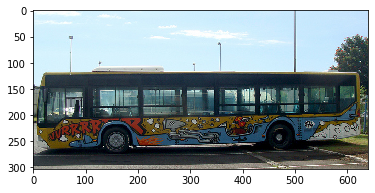

Predicted caption:
 a man on a skateboard in a park <end>



In [539]:
generate_caption(80000)

 a bus with a colorful design  on the bottom half 


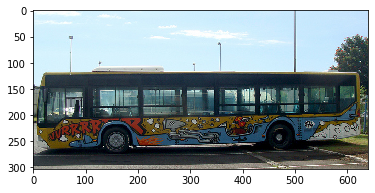

Predicted caption:
<start> a man holding a tennis racquet on top of a tennis court with a racket in his hand <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>



In [543]:
generate_caption_beam_search(80000, beam_width=5)

In [386]:
 # input X1: transfer values
transfer_values = X1train[2000].reshape((1, 4096))

# input X2: word token
shape = (1, 51)
decoder_input_data = np.zeros(shape=shape, dtype=np.int)

token_int = tokenizer.word_index['<start>']
token_end = tokenizer.word_index['<end>']
output_text = ''
count_tokens = 0

decoder_input_keep = []
combined_prob_keep = []

decoder_input_data[0, count_tokens] = token_int
decoder_input_keep.append(decoder_input_data)
combined_prob_keep=[1]

In [461]:
decoder_input_update = []
prob_update = []

### for loop

In [482]:
i = 2

In [483]:
decoder_output = model.predict([transfer_values, decoder_input_keep[i]])

In [484]:
decoder_output.shape

(1, 51, 10000)

In [485]:
token_int = np.argsort(decoder_output[0, count_tokens, :])[-3:][::-1]
token_int

array([11, 20,  2], dtype=int64)

In [486]:
prob = decoder_output[0, count_tokens, :][token_int]
prob

array([0.7251821 , 0.25821558, 0.00120603], dtype=float32)

In [487]:
combined_prob = combined_prob_keep[i] * prob
combined_prob

array([4.6829026e-02, 1.6674411e-02, 7.7880220e-05], dtype=float32)

In [488]:
decoder_input = []
for j in range(3):
    decoder_input_to_add = decoder_input_keep[i].copy()
    decoder_input_to_add[0,count_tokens+1] = token_int[j]
    decoder_input.append(decoder_input_to_add)
#decoder_input = np.asarray(decoder_input)
decoder_input

[array([[ 3, 65, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0]]),
 array([[ 3, 65, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0]]),
 array([[ 3, 65,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0]])]

In [489]:
prob_update = np.append(prob_update, combined_prob)
decoder_input_update.extend(decoder_input)

In [490]:
prob_update

array([3.34977470e-02, 3.08172479e-02, 2.98471898e-02, 2.26581637e-02,
       7.37354439e-03, 4.43680072e-03, 4.68290262e-02, 1.66744106e-02,
       7.78802205e-05])

In [491]:
decoder_input_update

[array([[ 3,  2, 45,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0]]),
 array([[ 3,  2, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0]]),
 array([[ 3,  2, 29,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0]]),
 array([[  3,  15, 276,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0, 

### end of for loop

In [492]:
keepers = np.argsort(prob_update)[-3:][::-1]

In [493]:
keepers

array([6, 0, 1], dtype=int64)

In [494]:
combined_prob_keep = prob_update[keepers]
combined_prob_keep

array([0.04682903, 0.03349775, 0.03081725])

In [495]:
decoder_input_keep = [decoder_input_update[i] for i in keepers]
decoder_input_keep

[array([[ 3, 65, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0]]),
 array([[ 3,  2, 45,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0]]),
 array([[ 3,  2, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0]])]

In [496]:
count_tokens += 1 

In [501]:
final_keeper = int(np.argsort(combined_prob_keep)[-1:])
output_tokens = decoder_input_keep[final_keeper]

In [504]:
output_tokens[0]

array([ 3, 65, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [511]:
sampled_words = [index_word[i] for i in list(output_tokens[0])]
' '.join(sampled_words)

'<start> there is <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>'

In [39]:
# fit model
# should train for 20, try 1 for now
%time history = model.fit([check_X1train, check_X2train], check_ytrain, epochs=10, verbose=2, callbacks=callbacks,\
                          validation_data=([check_X1val, check_X2val], check_yval))

C:\Users\Filabuster\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1000 samples, validate on 300 samples
Epoch 1/10

Epoch 00001: val_loss improved from inf to 1.75102, saving model to model-ep001-loss2.040-val_loss1.751.h5
 - 13s - loss: 2.0405 - val_loss: 1.7510
Epoch 2/10

Epoch 00002: val_loss improved from 1.75102 to 1.51939, saving model to model-ep002-loss1.223-val_loss1.519.h5
 - 10s - loss: 1.2232 - val_loss: 1.5194
Epoch 3/10

Epoch 00003: val_loss did not improve from 1.51939
 - 9s - loss: 1.1456 - val_loss: 3.3006
Epoch 4/10

Epoch 00004: val_loss improved from 1.51939 to 1.42066, saving model to model-ep004-loss1.107-val_loss1.421.h5
 - 9s - loss: 1.1066 - val_loss: 1.4207
Epoch 5/10

Epoch 00005: val_loss did not improve from 1.42066
 - 9s - loss: 1.0325 - val_loss: 1.4340
Epoch 6/10

Epoch 00006: val_loss improved from 1.42066 to 1.40475, saving model to model-ep006-loss1.002-val_loss1.405.h5
 - 9s - loss: 1.0024 - val_loss: 1.4048
Epoch 7/10

Epoch 00007: val_loss improved from 1.40475 to 1.34711, saving model to model-ep007-l